# Treinamento de 4 modelos - modelo multinomial logístico e modelos de redes MLP com 1, 2 e 3 camadas - para identificação de dígitos de 0 a 9 escritos à mão. Para isso, foi feito o download dos dados MNIST de treino e de teste disponíveis por exemplo em https://pjreddie.com/projects/mnist-in-csv/

In [18]:
import csv
import numpy as np

with open("mnist_test.csv", "r") as _:
    mnist_test_csv = csv.reader(_, delimiter = ",")
    test_data_np = np.array([linha for linha in mnist_test_csv], dtype=float)

with open("mnist_train.csv", "r") as _:
    mnist_train_csv = csv.reader(_, delimiter = ",")
    training_data_np = np.array([linha for linha in mnist_train_csv], dtype=float)

print(training_data_np.shape)
print(test_data_np.shape)

(60000, 785)
(10000, 785)


In [19]:
print( type(training_data_np[0][0]) )

<class 'numpy.float64'>


## Plote das 5 primeiras imagens do conjunto de treino.

In [20]:
import matplotlib.pyplot as plt

Resposta real da imagem: 5.0


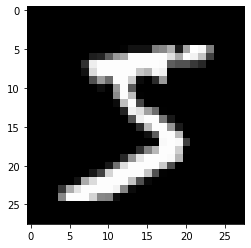

Resposta real da imagem: 0.0


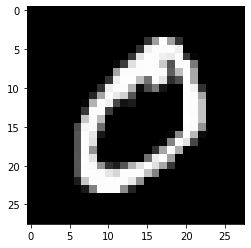

Resposta real da imagem: 4.0


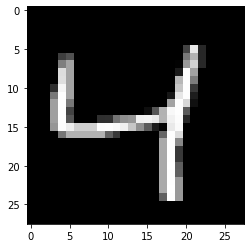

Resposta real da imagem: 1.0


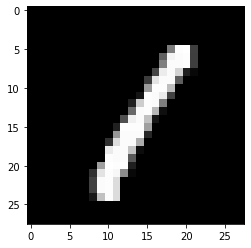

Resposta real da imagem: 9.0


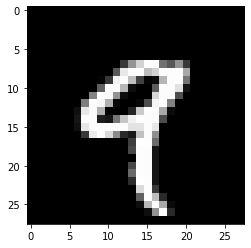

In [21]:
# Plotando as 5 primeiras imagens do conjunto de treino

for obs in range(0,5):
  img = training_data_np[obs, 1:].reshape((28, 28)) # Pegando os pixels da i-ésima imagem e transformando em uma que possui tamanho 28x28
  label = training_data_np[obs, 0] # Pegando a primeira info que se refere a verdadeira resposta do conjunto treino

  print('Resposta real da imagem:', label) # Printando o resultado real

  plt.imshow(img, cmap='gray') # Plotando a imagem em tons de cinza
  plt.show()

## Divisão dos dados que formam o conjunto de treino em duas partes: primeiras 55000 observações como sendo o conjunto de treino e 5000 observações seguintes como conjunto de validação.

In [22]:
# Separando a base de treinamento em conjunto de treino (~90%) e conjunto de validação (~10%)

conjunto_de_treino = training_data_np[:55000, 1:]
conjunto_de_validação = training_data_np[55000:, 1:]

print("Conjunto de treino corresponde a ", np.round(100*len(conjunto_de_treino)/len(training_data_np), decimals = 0), "% da base de treino e o conjunto de validação corresponde a ", np.round(100*len(conjunto_de_validação)/len(training_data_np), decimals = 0), "%")

Conjunto de treino corresponde a  92.0 % da base de treino e o conjunto de validação corresponde a  8.0 %


## Histograma com as intensidades dos pixels que formam a primeira imagem e rescalonamento dos pixels de tal modo que suas intensidades estejam contidas no intervalo [0, 1] e as ocorrências de 0 sejam preservadas.

Text(0, 0.5, 'Frequência de ocorrências')

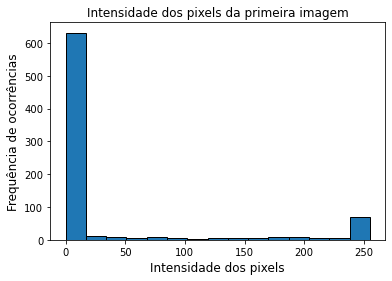

In [23]:
# Fazendo o histograma das intensidades dos pixels da primeira imagem do conjunto de treinamento
plt.hist(conjunto_de_treino[0, :], bins=15, edgecolor='black')

# Adicionando descrições ao gráfico
plt.title("Intensidade dos pixels da primeira imagem")
plt.xlabel("Intensidade dos pixels", fontsize = 12)
plt.ylabel("Frequência de ocorrências", fontsize = 12)

Uma forma de tratamento é normalizar - nesse caso, dividir pelo maior valor - o vetor de intensidades dos pixels para que ele pertença ao intervalo [0, 1]. Dessa modo, ainda peservamos as ocorrências iguais a 0

A maior intensidade de pixel da base é:  1.0


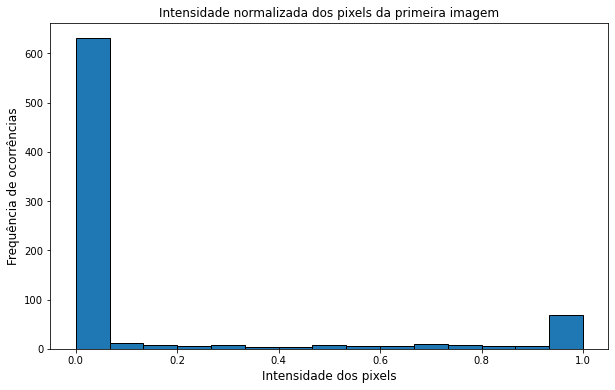

In [24]:
# Fazendo o histograma das intensidades normalizadas dos pixels da primeira imagem do conjunto de treinamento

# Normalizando os conjuntos
conjunto_de_treino = training_data_np[:55000, 1:] / 255 # 255 é o maior valor relacionado a intensidade do pixel
conjunto_de_validação = training_data_np[55000:, 1:] / 255

#Print do valor máximo do pixel
print("A maior intensidade de pixel da base é: ", max(conjunto_de_treino[0, :]))

# Fazendo o plot
plt.figure(figsize=(10, 6))
plt.hist(conjunto_de_treino[0, :], bins=15, edgecolor='black')

# Adicionando descrições ao gráfico
plt.title("Intensidade normalizada dos pixels da primeira imagem", fontsize = 12)
plt.xlabel("Intensidade dos pixels", fontsize = 12)
plt.ylabel("Frequência de ocorrências", fontsize = 12)

plt.show()
# É possível notar que todas as ocorências estão entre 0 e 1

## Rodando o algoritmo do gradiente ascendente estocástico variando as taxas de aprendizagem no conjunto γ ∈ {2, 1, 0.1, 0.01} - fixado um tamanho de batch.

In [26]:
conda install -c pytorch torchaudio

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/rafaelafonso/opt/anaconda3

  added / updated specs:
    - torchaudio


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pytorch-2.2.2              |          py3.9_0        87.2 MB  pytorch
    torchaudio-2.2.2           |         py39_cpu         4.8 MB  pytorch
    ------------------------------------------------------------
                                           Total:        91.9 MB

The following NEW packages will be INSTALLED:

  pytorch            pytorch/osx-64::pytorch-2.2.2-py3.9_0 None
  torchaudio         pytorch/osx-64::torchaudio-2.2.2-py39_cpu None



pytorch-2.2.2        | 87.2 MB   | ###########################

In [28]:
import torch

# print installed version of PyTorch
print( torch.__version__ )

# importando o modulo nn do Pytorch para criar as redes
import torch.nn as nn

# importando biblioteca com funções úteis para a rede
import torch.nn.functional as F

2.2.2


In [29]:
# Definindo os 3 conjuntos diferentes das bases importadas: treino, validação e teste
training_data = torch.tensor(training_data_np[0:55000, :])
validation_data = torch.tensor(training_data_np[55000:60000, :])
test_data = torch.tensor(test_data_np)

print(validation_data.shape)
print(validation_data)

torch.Size([5000, 785])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [2., 0., 0.,  ..., 0., 0., 0.],
        [8., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [5., 0., 0.,  ..., 0., 0., 0.],
        [6., 0., 0.,  ..., 0., 0., 0.],
        [8., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


In [30]:
#Inicializando a classe da rede

class Network3(nn.Module):  # Criando a classe da rede que será usada para treinamento como extensão do módulo nn

    def __init__(self):
        super().__init__()

        # 1ª camada latente
        self.fc1 = nn.Linear(in_features = 28*28, out_features = 200, bias = True, dtype = torch.float64)
        # 2ª Camada latente
        self.fc2 = nn.Linear(in_features = 200, out_features = 100, bias = True, dtype = torch.float64)
        # 3ª Camada latente
        self.fc3 = nn.Linear(in_features = 100, out_features = 50, bias = True, dtype = torch.float64)
        # Camada de saída
        self.out = nn.Linear(in_features = 50, out_features = 10, bias = True, dtype = torch.float64)

    def forward(self, t):

        # Função de ligação da 1ª camada
        t = self.fc1(t)
        t = F.relu(t)
        # Função de ligação da 2ª camada
        t = self.fc2(t)
        t = F.relu(t)
        # Função de ligação da 2ª camada
        t = self.fc3(t)
        t = F.relu(t)
        # Função de ligação da saída
        t = self.out(t)
        t = F.softmax(t, dim=1)

        return t

# criando uma variável que chama a função
net = Network3()

# Analisando os parâmetros da rede
print(net)
print(net.parameters() )

Network3(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=10, bias=True)
)
<generator object Module.parameters at 0x7f81a46f93c0>


In [31]:
gammas = [2, 1, 0.01, 0.1] # Vetor de possíveia gammas de estudo

def get_accuracy(preds, labels): # Função para analisar a acurácia do treinamento
  return torch.mean(preds.argmax(dim=1).eq(labels).float() )

# Definindo constantes importantes para a rede
n = 55000
p = 28*28
batch_size = 6875
n_epochs = 50

# Extraindo os vetores X de validação e Y de respostas
X_valid = validation_data[:, 1:(p+1)]
y_valid = validation_data[:, 0]

# Armazenando as precisões dos modelos
precisoes = np.empty((len(gammas), n_epochs))

for i, gamma in enumerate(gammas):

  # Criando a variável da rede para um certo gamma
  network = Network3()


  train_loader = torch.utils.data.DataLoader(training_data, batch_size = batch_size) # Definindo os batchs dasiterações
  optimizer = torch.optim.SGD(network.parameters(), lr=gamma) # Definindo a otimização dos pesos a partir do peso gamma da iteração

  #Identificando o começo do treinamento para o gamma específico a partir do print
  print(f"Treinando a rede para taxa de aprendizado γ = {gamma} \n")

  for epoch in range(n_epochs):

    total_loss = 0
    total_accuracy = 0

    for data_batch in train_loader: # Pegando cada um  dos batchs criado

        # Criando os vetores X do batch e Y de respostas
        X_batch = data_batch[:, 1:(p+1)]
        y_batch = data_batch[:, 0]

        y_hat_batch = network(X_batch) # Calculando o vetor de resposta a partir do batch criado
        loss = F.cross_entropy(y_hat_batch, y_batch.type(torch.LongTensor) ) # Calculando a perda

        optimizer.zero_grad() # Zerando
        loss.backward() # Calculando o gradiente
        optimizer.step() # Atualizando os pesos

        # Calculando a perda e acurácia da rede
        total_loss += loss.item()
        total_accuracy += get_accuracy(y_hat_batch, y_batch)

    # Criando o print de resultados para cada época
    if epoch % 1 == 0:

      # Calculando a acurácia
      y_hat_valid = network(X_valid)
      valid_accuracy = get_accuracy(y_hat_valid, y_valid)

      # Gerando o print do resultado da época
      print(
          "epoch:", epoch,
          "train accuracy:", round( (total_accuracy/(n/batch_size)).item(), 4),
          "validation accuracy:", round( valid_accuracy.item(), 4),
          "loss:", round(total_loss, 4)
      )

      # Armazenando a evolução da acurácia do modelo
      precisoes[i][epoch] = round( valid_accuracy.item(), 4)


  # Criando os vetores X do teste e Y de respostas
  X_test = test_data[:, 1:(p+1)]
  y_test = test_data[:, 0]

  # Usando o modelo treinado para predizer resultados sobre o conjunto teste (desconhecido para a rede)
  y_hat_test = network(X_test)
  test_accuracy = get_accuracy(y_hat_test, y_test)

  print("\n test_accuracy: ", test_accuracy)

  print("\n" + 80*"-" + "\n")

Treinando a rede para taxa de aprendizado γ = 2 

epoch: 0 train accuracy: 0.1038 validation accuracy: 0.1126 loss: 18.8429
epoch: 1 train accuracy: 0.1037 validation accuracy: 0.1126 loss: 18.8598
epoch: 2 train accuracy: 0.1037 validation accuracy: 0.1126 loss: 18.8598
epoch: 3 train accuracy: 0.1037 validation accuracy: 0.1126 loss: 18.8598
epoch: 4 train accuracy: 0.1037 validation accuracy: 0.1126 loss: 18.8598
epoch: 5 train accuracy: 0.1037 validation accuracy: 0.1126 loss: 18.8598
epoch: 6 train accuracy: 0.1037 validation accuracy: 0.1126 loss: 18.8598
epoch: 7 train accuracy: 0.1037 validation accuracy: 0.1126 loss: 18.8598
epoch: 8 train accuracy: 0.1037 validation accuracy: 0.1126 loss: 18.8598
epoch: 9 train accuracy: 0.1037 validation accuracy: 0.1126 loss: 18.8598
epoch: 10 train accuracy: 0.1037 validation accuracy: 0.1126 loss: 18.8598
epoch: 11 train accuracy: 0.1037 validation accuracy: 0.1126 loss: 18.8598
epoch: 12 train accuracy: 0.1037 validation accuracy: 0.1126

## Plote da precisão no conjunto de validação a cada época para cada uma das escolhas de γ e reporte do melhor valor de γ com base no gráfico.

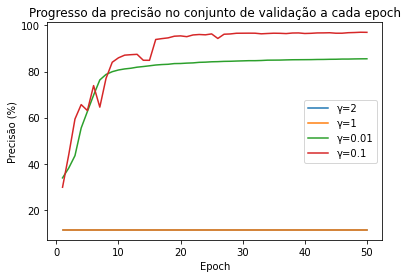

In [32]:
epochs = range(1, n_epochs+1) # Criando o vetor x de épocas

for i, gamma in enumerate(gammas): # Fazendo o plot de cada evolução da acurácia relacionada ao seu gamma específico
  plt.plot(epochs, 100*precisoes[i], label = f"γ={gamma}")

# Criando algumas descrições para o plot
plt.title("Progresso da precisão no conjunto de validação a cada epoch")
plt.xlabel("Epoch")
plt.ylabel("Precisão (%)")
plt.legend()

## Rodando o algoritmo do gradiente ascendente estocástico para treinar um modelo MLP com 1 camada, 2 camadas e 3 camadas - fixado um tamanho de batch e uma taxa de aprendizagem.

In [33]:
#Inicializando as classes das redes a sereme testadas

class Network_Log(nn.Module):  # Criando a classe rede Logistica (e uma camada) que será usada para treinamento como extensão do módulo nn

    def __init__(self):
        super().__init__()

        # Camada de saída
        self.out = nn.Linear(in_features = 28*28, out_features = 10, bias = True, dtype = torch.float64)

    def forward(self, t):
        # Função de ligação da 1ª camada
        t = self.out(t)
        t = F.softmax(t, dim=1)

        return t

class Network1(nn.Module):  # Criando a classe rede Logistica (e uma camada) que será usada para treinamento como extensão do módulo nn

    def __init__(self):
        super().__init__()

        # 1ª camada latente
        self.fc1 = nn.Linear(in_features = 28*28, out_features = 50, bias = True, dtype = torch.float64)

        # Camada de saída
        self.out = nn.Linear(in_features = 50, out_features = 10, bias = True, dtype = torch.float64)

    def forward(self, t):
        # Função de ligação da 1ª camada
        t = self.fc1(t)
        t = F.softmax(t, dim=1)

        # Função de ligação da saída da rede
        t = self.out(t)
        t = F.softmax(t, dim=1)

        return t

class Network2(nn.Module):  # Criando a classe da rede com duas camadas que será usada para treinamento como extensão do módulo nn
    def __init__(self):
        super().__init__()

        # 1ª camada latente
        self.fc1 = nn.Linear(in_features = 28*28, out_features = 100, bias = True, dtype = torch.float64)

        # 2ª camada latente
        self.fc2 = nn.Linear(in_features = 100, out_features = 50, bias = True, dtype = torch.float64)

        # Camada de saída
        self.out = nn.Linear(in_features = 50, out_features = 10, bias = True, dtype = torch.float64)


    def forward(self, t):
        # Função de ligação da 1ª camada
        t = self.fc1(t)
        t = F.relu(t)

        # Função de ligação da 2ª camada
        t = self.fc2(t)
        t = F.relu(t)

        # Função de ligação da saída da rede
        t = self.out(t)
        t = F.softmax(t, dim=1)

        return t

In [34]:
nets = [Network_Log(), Network1(), Network2(), Network3()] # Vetor de possíveia redes de estudo
nomes = ["Multinomial Logística", "1 Camada", "2 Camadas", "3 Camadas"] # Criando um vetor com nomes das possíveis redes

# Definindo constantes importantes para a rede
n = 55000
p = 28*28
batch_size = 6875
n_epochs = 50

# Extraindo os vetores X de validação e Y de respostas
X_valid = validation_data[:, 1:(p+1)]
y_valid = validation_data[:, 0]

# Armazenando as precisões dos modelos
precisoes = np.empty((len(nets), n_epochs))

for i, net in enumerate(nets):
  network = net # Criando uma várivel com a rede a ser usada em cada iteração

  train_loader = torch.utils.data.DataLoader(training_data, batch_size = batch_size) # Definindo os batchs das iterações
  optimizer = torch.optim.SGD(network.parameters(), lr=0.1) # Definindo a otimização dos pesos a partir do gamma definido anteriormente

  print(f"Treinando a rede para {nomes[i]} \n") #Identificando o começo do treinamento para o gamma específico a partir do print

  for epoch in range(n_epochs): # Fazendo as iterações das épocas

    total_loss = 0
    total_accuracy = 0

    for data_batch in train_loader: # Pegando cada um  dos batchs criado
# Criando os vetores X do batch e Y de respostas
        X_batch = data_batch[:, 1:(p+1)]
        y_batch = data_batch[:, 0]

        y_hat_batch = network(X_batch) # Calculando o vetor de resposta a partir do batch criado
        loss = F.cross_entropy(y_hat_batch, y_batch.type(torch.LongTensor) ) # Calculando a perda

        optimizer.zero_grad() # Zerando
        loss.backward() # Calculando o gradiente
        optimizer.step() # Atualizando os pesos

# Calculando a perda e acurácia da rede
        total_loss += loss.item()
        total_accuracy += get_accuracy(y_hat_batch, y_batch)

    # Criando o print de resultados para cada época
    if epoch % 1 == 0:

      # calculate accuracy on validation dataset
      y_hat_valid = network(X_valid)
      valid_accuracy = get_accuracy(y_hat_valid, y_valid) # Calculando a acurácia

      # Gerando o print do resultado da época
      print(
          "epoch:", epoch,
          "train accuracy:", round( (total_accuracy/(n/batch_size)).item(), 4),
          "validation accuracy:", round( valid_accuracy.item(), 4),
          "loss:", round(total_loss, 4)
      )

      # Armazenando a evolução da acurácia do modelo
      precisoes[i][epoch] = round(valid_accuracy.item(), 4)

  # Criando os vetores X do teste e Y de respostas
  X_test = test_data[:, 1:(p+1)]
  y_test = test_data[:, 0]

  # Usando o modelo treinado para predizer resultados sobre o conjunto teste (desconhecido para a rede)
  y_hat_test = network(X_test)
  test_accuracy = get_accuracy(y_hat_test, y_test)

  print("\n test_accuracy: ", test_accuracy) # Print da acurácia relacionada ao conjunto teste

  print("\n" + 80*"-" + "\n") # Separando os resultados das redes distintas

Treinando a rede para Multinomial Logística 

epoch: 0 train accuracy: 0.2365 validation accuracy: 0.2966 loss: 17.7898
epoch: 1 train accuracy: 0.4196 validation accuracy: 0.482 loss: 16.3266
epoch: 2 train accuracy: 0.4708 validation accuracy: 0.491 loss: 15.9176
epoch: 3 train accuracy: 0.4781 validation accuracy: 0.494 loss: 15.8595
epoch: 4 train accuracy: 0.4741 validation accuracy: 0.4944 loss: 15.8928
epoch: 5 train accuracy: 0.4825 validation accuracy: 0.4958 loss: 15.8262
epoch: 6 train accuracy: 0.4876 validation accuracy: 0.4946 loss: 15.7846
epoch: 7 train accuracy: 0.4864 validation accuracy: 0.4982 loss: 15.7945
epoch: 8 train accuracy: 0.4904 validation accuracy: 0.4978 loss: 15.763
epoch: 9 train accuracy: 0.4908 validation accuracy: 0.4996 loss: 15.7599
epoch: 10 train accuracy: 0.4898 validation accuracy: 0.4986 loss: 15.7674
epoch: 11 train accuracy: 0.4958 validation accuracy: 0.5118 loss: 15.72
epoch: 12 train accuracy: 0.5078 validation accuracy: 0.5338 loss: 15.

## Plote da precisão no conjunto de validação a cada época para cada um dos 3 modelos MLP e do modelo de regressão multinomial logística e reporte do melhor deles com base no gráfico.

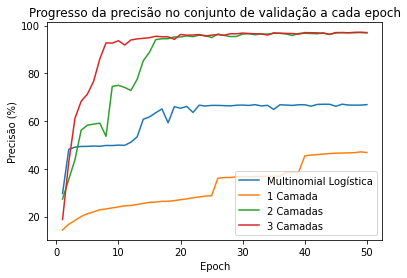

In [35]:
epochs = range(1, n_epochs+1) # Criando o vetor de épocas para o print

for i in range(len(nets)): # Fazendo o print para cada evolução das redes trabalhadas
  plt.plot(epochs, 100*precisoes[i], label = f"{nomes[i]}")

# Criando algumas descrições para o plot
plt.title("Progresso da precisão no conjunto de validação a cada epoch")
plt.xlabel("Epoch")
plt.ylabel("Precisão (%)")
plt.legend()

## Combinando o resultado dos 4 modelos treinados - regressão multinomial logística, MLP com 1 camada, MLP com 2 camadas, MLP com 3 camadas - e tirando a média entre as estimativas para as probabilidades de cada classe segundo cada um dos modelos no conjunto de validação. 
OBS: O modelo combinado (também chamado de ensemble) terá como ouput o valor médio das previsões individuais.

In [36]:
nets = [Network_Log(), Network1(), Network2(), Network3()] # Vetor das redes que serão usadas no modelo

# Definindo constantes importantes para a rede
n = 55000
p = 28*28
batch_size = 2750
n_epochs = 50

# Extraindo os vetores X de validação e Y de respostas
X_valid = validation_data[:, 1:(p+1)]
y_valid = validation_data[:, 0]

# Armazenando as precisões dos modelos
precisoes = np.empty(n_epochs)

# create network as an instance of Network() class defined previously

train_loader = torch.utils.data.DataLoader(training_data, batch_size = batch_size) # Definindo os batchs das iterações
optimizers = [torch.optim.SGD(network.parameters(), lr=0.1) for network in nets] # Definindo a otimização dos pesos a partir do gamma definido

for epoch in range(n_epochs):

  total_loss = 0
  total_accuracy = 0

  for data_batch in train_loader: # Pegando cada um  dos batchs criado
# Criando os vetores X do batch e Y de respostas
      X_batch = data_batch[:, 1:(p+1)]
      y_batch = data_batch[:, 0]

      # Calculando o um tensor médio a partir da média dos tensores individuais de cada rede
      y_hat_batchs_modelos = [network(X_batch) for network in nets]
      stacked_tensors = torch.stack(y_hat_batchs_modelos , dim=0)

      y_hat_batch = torch.mean(stacked_tensors, dim=0) # Calculando o vetor de resposta a partir do batch criado

      loss = F.cross_entropy(y_hat_batch, y_batch.type(torch.LongTensor) ) # Calculando a perda

      # Zerando todos os otimizadores
      for optimizer in optimizers:
        optimizer.zero_grad()

      loss.backward() # Calculando o gradiente

      # Atualizando os pesos de cada rede
      for optimizer in optimizers:
        optimizer.step()

      # Calculando a perda e acurácia da rede
      total_loss += loss.item()
      total_accuracy += get_accuracy(y_hat_batch, y_batch)

  # Gerando o print do resultado da época
  if epoch % 1 == 0:

    # Calculando o um tensor médio a partir da média dos tensores individuais de cada rede
    y_hat_valids_modelos = [network(X_valid) for network in nets]
    stacked_tensors = torch.stack(y_hat_valids_modelos, dim=0)

    # Respostas do modelo
    y_hat_valid = torch.mean(stacked_tensors, dim=0)

    valid_accuracy = get_accuracy(y_hat_valid, y_valid) # Calculando a acurácia

    print(
        "epoch:", epoch,
        "train accuracy:", round( (total_accuracy/(n/batch_size)).item(), 4),
        "validation accuracy:", round( valid_accuracy.item(), 4),
        "loss:", round(total_loss, 4)
    )

  # Armazenando a evolução da acurácia do modelo
  precisoes[epoch] = round(valid_accuracy.item(), 4)


# Criando os vetores X do teste e Y de respostas
X_test = test_data[:, 1:(p+1)]
y_test = test_data[:, 0]

# Usando o modelo treinado para predizer resultados sobre o conjunto teste (desconhecido para a rede)

# Calculando o um tensor médio a partir da média dos tensores individuais de cada rede
y_hat_tests_modelos = [network(X_test) for network in nets]
stacked_tensors = torch.stack(y_hat_tests_modelos, dim=0)

# Respostas do modelo
y_hat_test = torch.mean(stacked_tensors, dim=0)

test_accuracy = get_accuracy(y_hat_test, y_test) # Calculando a acurácia do modelo a partir do conjunto teste (desconhecido pelo modelo)

print("\n test_accuracy: ", test_accuracy) # Print da acurácia do modelo a partir do conjunto teste (desconhecido pelo modelo)

epoch: 0 train accuracy: 0.4082 validation accuracy: 0.5738 loss: 42.8446
epoch: 1 train accuracy: 0.5808 validation accuracy: 0.6416 loss: 40.3816
epoch: 2 train accuracy: 0.7067 validation accuracy: 0.7634 loss: 39.5679
epoch: 3 train accuracy: 0.7432 validation accuracy: 0.7768 loss: 39.0485
epoch: 4 train accuracy: 0.753 validation accuracy: 0.7844 loss: 38.6536
epoch: 5 train accuracy: 0.7633 validation accuracy: 0.788 loss: 38.3549
epoch: 6 train accuracy: 0.7716 validation accuracy: 0.7948 loss: 38.0564
epoch: 7 train accuracy: 0.7772 validation accuracy: 0.8012 loss: 37.8013
epoch: 8 train accuracy: 0.7695 validation accuracy: 0.7886 loss: 37.4179
epoch: 9 train accuracy: 0.7717 validation accuracy: 0.788 loss: 37.2264
epoch: 10 train accuracy: 0.7752 validation accuracy: 0.7942 loss: 37.0076
epoch: 11 train accuracy: 0.7792 validation accuracy: 0.7928 loss: 36.8662
epoch: 12 train accuracy: 0.7845 validation accuracy: 0.7964 loss: 36.8227
epoch: 13 train accuracy: 0.788 valida

O modelo a cima possui uma acurácia razoavelmente próxima a rede da letra c, contudo ele atingiu de forma muito mais rápida uma boa acurácia de validação se comparado à rede da letra c

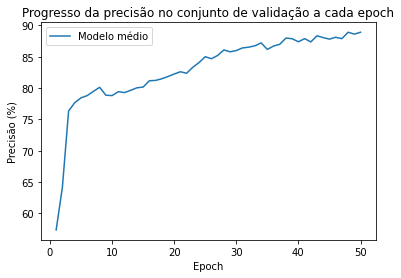

In [37]:
epochs = range(1, n_epochs+1) # Criando o vetor de épocas para oi plot

plt.plot(epochs, 100*precisoes, label = "Modelo médio") # Plotando a precisão do modelo passado

# Criando algumas descrições do plot
plt.title("Progresso da precisão no conjunto de validação a cada epoch")
plt.xlabel("Epoch")
plt.ylabel("Precisão (%)")
plt.legend()

## Plote de alguns erros

In [38]:
topk_values, topk_indices = torch.topk(y_hat_test, 1, dim=1)
topk_indices = y_hat_test.argmax(dim=1)

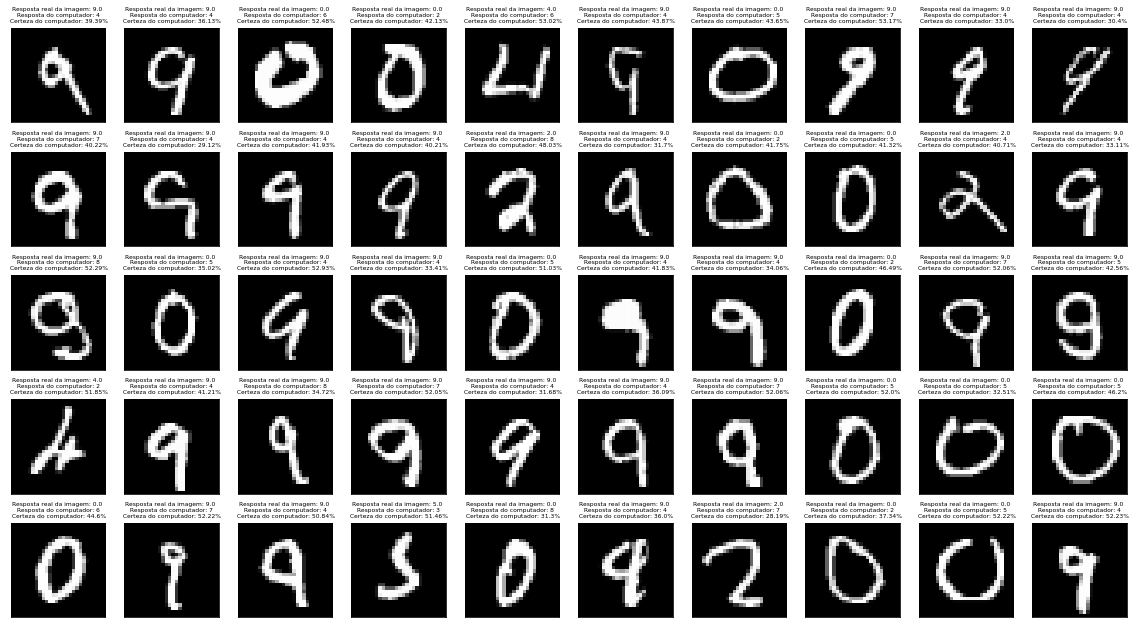

In [40]:
# Fazendo o mesmo loop a cima para as mesma intenção só que com mais imagens

plt.figure(figsize=(20, 11))
cont = 0

for obs in range(0,10000):
  label = test_data_np[obs, 0]
  comp_ans = int(topk_indices[obs])
  porc = float(topk_values[obs])

  if label != comp_ans and porc<0.7:

    if cont<50:
      ax = plt.subplot(5, 10, cont + 1)
      plt.imshow(test_data_np[obs, 1:].reshape((28, 28)))
      ax.set_title(f'Resposta real da imagem: {label} \n Resposta do computador: {comp_ans} \n Certeza do computador: {round(100*porc, 2)}%', fontsize = 6)
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      cont += 1

    else: break

plt.show()